In [1]:
%%time
# !head -n 20 bluetooth_graph_analysis.py 
!awk 'FNR>=28 && FNR<=50' bluetooth_graph_analysis.py
%run bluetooth_graph_analysis.py
%matplotlib inline

from speclib import misc, plotting, loaders, graph  # noqa
PRINT = False
PRINT_PROGRESS = True


# @jit()
def compareDfUsers(baseuser, peers, df, simfnc):
    # Compute the similarity in the way they answered the questions
    dct = dict()
    for i in range(len(peers)):
        dct[(baseuser, peers[i])] = simfnc(df.loc[baseuser], df.loc[peers[i]])
    sim = pd.Series(dct).sort_values(ascending=False)
    return sim


dfa  = pd.read_msgpack('/lscr_paper/allan/allan_data/participants_graph_adjacency.msgpack')
mask = dfa.sum() != 0
dfa  = dfa.loc[mask, mask]  # drop zero-columns
if PRINT: print(dfa.head())  # noqa
qdf  = pd.read_json('/lscr_paper/allan/allan_data/RGender_.json')
f    = misc.QuestionFilterer(qdf)
ua   = loaders.Useralias()

Processing user u0001 (0/842)


/lscr_paper/allan/scripts/speclib/graph.py:562: RuntimeWarning: invalid value encountered in double_scalars
  return np.dot(ua, ub)/(np.sqrt(ua**2).sum() * np.sqrt(ub**2).sum())
/lscr_paper/allan/scripts/speclib/graph.py:590: RuntimeWarning: invalid value encountered in double_scalars
  return 2*np.dot(ua, ub) / (np.dot(ua, ua) + np.dot(ub, ub))


Processing user u0048 (40/842)
Processing user u0094 (80/842)
Processing user u0141 (120/842)
Processing user u0197 (160/842)
Processing user u0249 (200/842)
Processing user u0306 (240/842)
Processing user u0361 (280/842)
Processing user u0413 (320/842)
Processing user u0465 (360/842)
Processing user u0518 (400/842)
Processing user u0569 (440/842)
Processing user u0618 (480/842)
Processing user u0664 (520/842)
Processing user u0711 (560/842)
Processing user u0760 (600/842)
Processing user u0809 (640/842)
Processing user u0860 (680/842)
Processing user u0902 (720/842)
Processing user u0949 (760/842)
Processing user u1004 (800/842)
Processing user u1057 (840/842)
CPU times: user 4min 13s, sys: 2.69 s, total: 4min 16s
Wall time: 4min 15s


In [2]:
df = pd.DataFrame(qdct)
df = df.fillna(0)
df.columns.names = ['user', 'question', 'group', 'simfnc'] 

In [3]:
dfc = df.T.groupby(level=[1,2,3]).agg(['mean', 'std']).T
dfc = dfc.fillna(method='ffill') 

In [4]:
dfc.head() 

question   alcohol                                       bfi             \
group      control               homies              control              
simfnc      cosSim normDotSim    cosSim normDotSim    cosSim normDotSim   
0 mean    0.150708   0.512301  0.156143   0.544853  0.025926   0.896905   
  std     0.120782   0.272771  0.126828   0.280010  0.001663   0.045180   
1 mean    0.089669   0.282683  0.097479   0.308835  0.024915   0.868445   
  std     0.053640   0.212676  0.074295   0.231450  0.001427   0.048364   
2 mean    0.048389   0.119586  0.056085   0.150861  0.023828   0.825564   

question                      homophily               ...     selfesteem  \
group       homies              control               ...         homies   
simfnc      cosSim normDotSim    cosSim normDotSim    ...         cosSim   
0 mean    0.025983   0.898951  0.107997   0.859181    ...       0.140956   
  std     0.001684   0.044603  0.011275   0.080418    ...       0.029117   
1 mean    0.025029   0.871905  0.100033   0.793756    ...       0.126212   
  std     0.001477   0.048247  0.009016   0.091343    ...       0.024643   
2 mean    0.024062   0.835680  0.091836   0.704874    ...       0.108250   

question               stress                                  symptoms  \
group                 control               homies              control   
simfnc   normDotSim    cosSim normDotSim    cosSim normDotSim    cosSim   
0 mean     0.899887  0.132380   0.896519  0.132148   0.895888  0.169278   
  std      0.091242  0.040756   0.083841  0.028228   0.092228  0.137563   
1 mean     0.843461  0.117133   0.839956  0.118962   0.843542  0.088653   
  std      0.109243  0.020469   0.099541  0.021699   0.102001  0.072602   
2 mean     0.736896  0.100713   0.734383  0.104679   0.755322  0.035121   

question                                  
group                  homies             
simfnc   normDotSim    cosSim normDotSim  
0 mean     0.458324  0.174368   0.463311  
  std      0.228018  0.144775   0.228752  
1 mean     0.276940  0.089855   0.277331  
  std      0.195157  0.080172   0.197095  
2 mean     0.117710  0.037554   0.125146  

[5 rows x 48 columns]

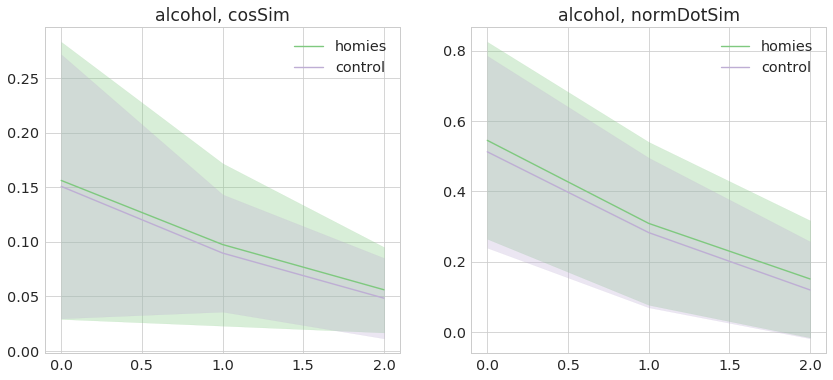

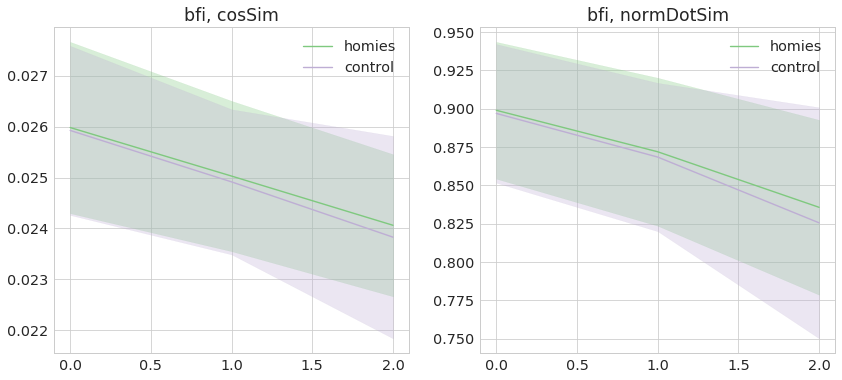

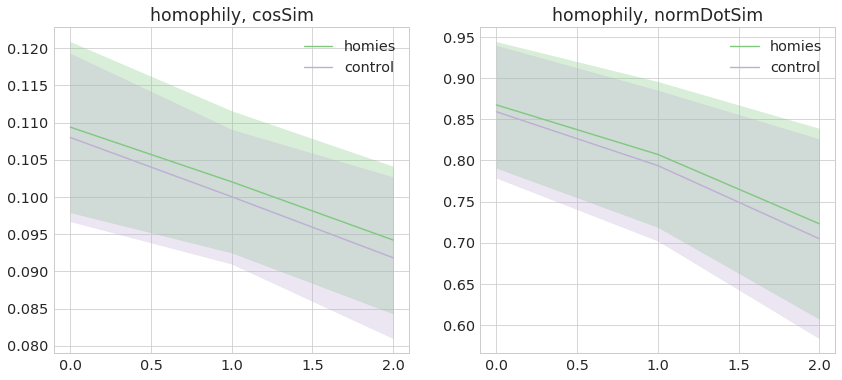

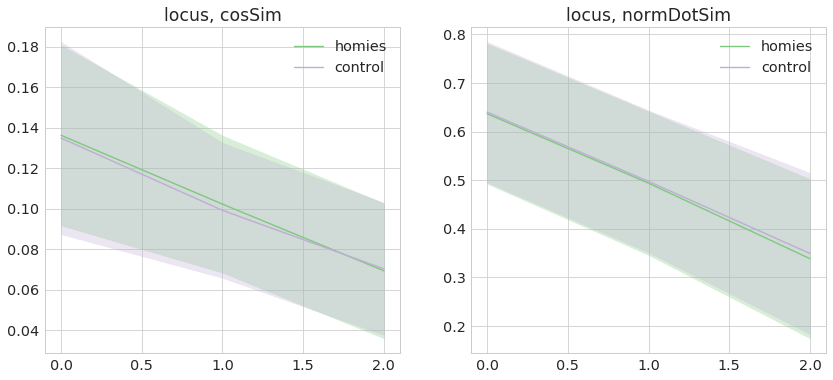

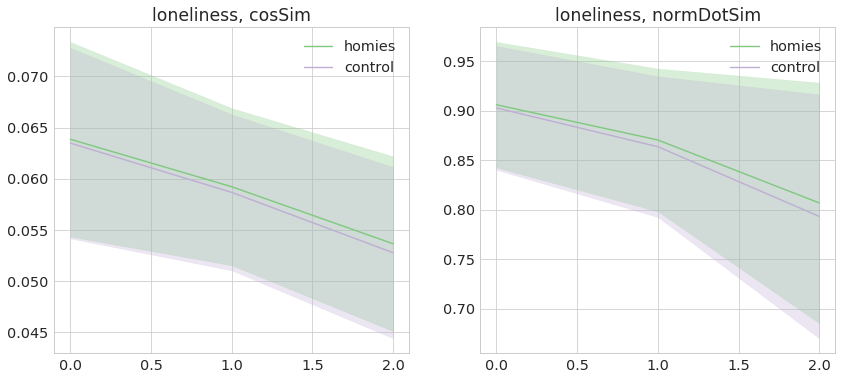

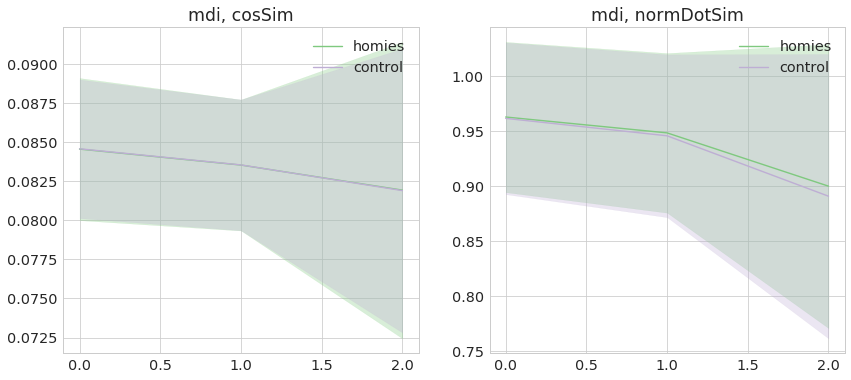

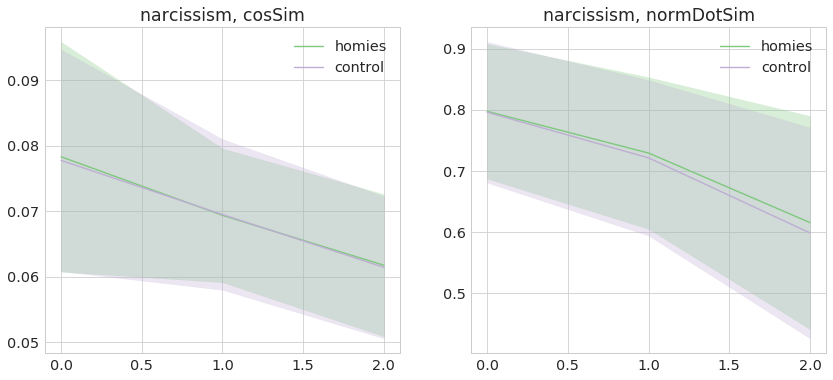

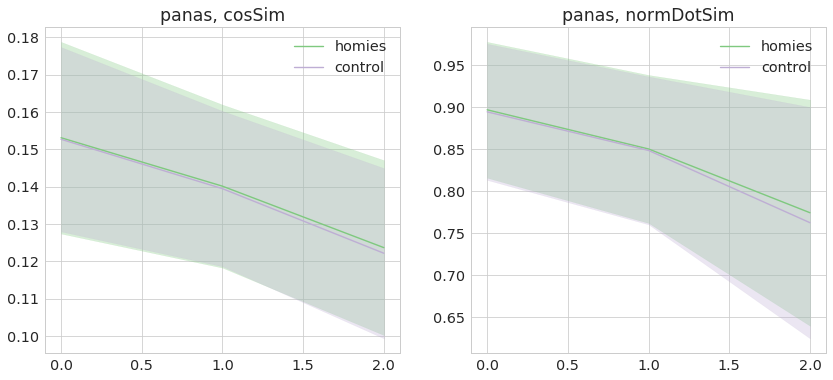

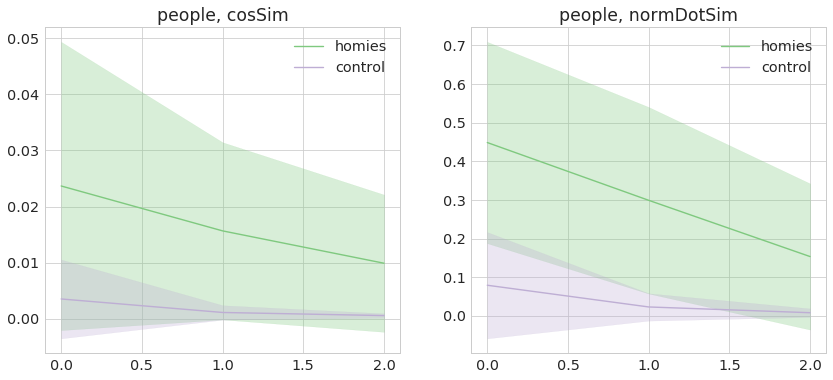

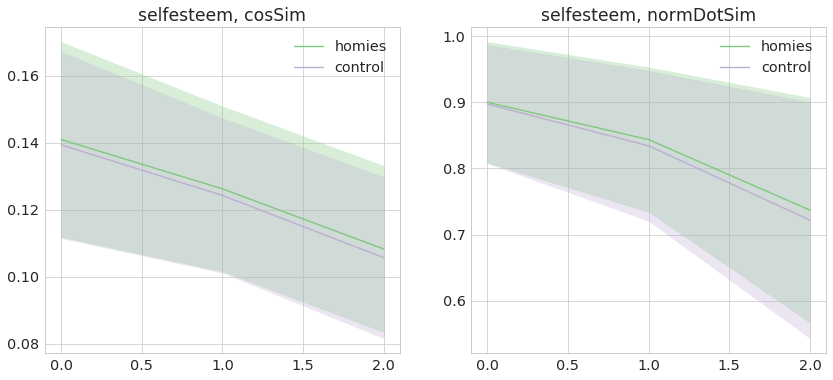

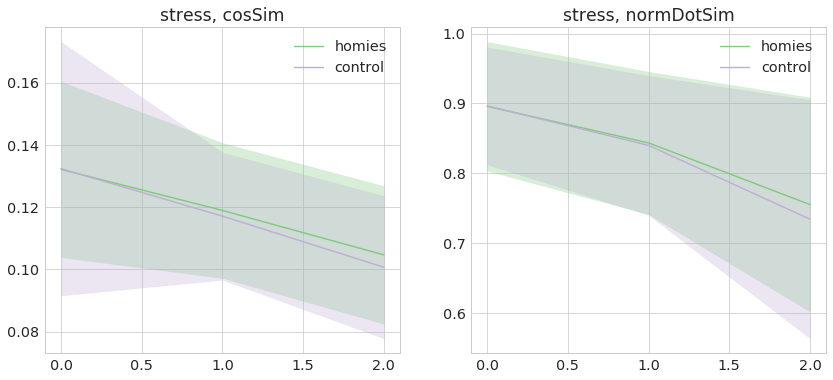

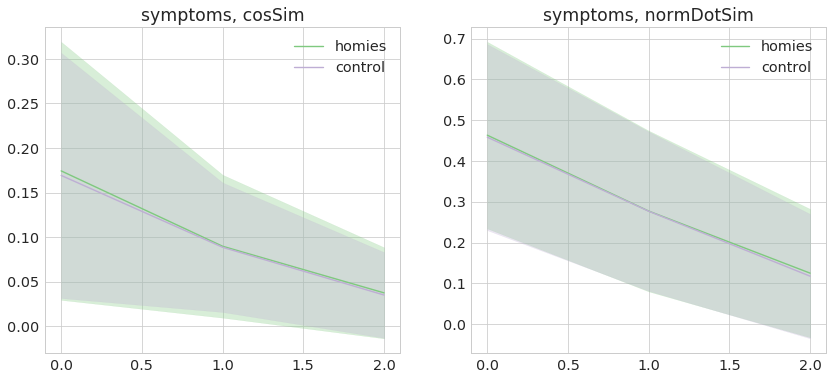

In [5]:
idx = pd.IndexSlice

for qst in dfc.columns.get_level_values('question').unique():
    fig, axi = plt.subplots(1, 2, figsize=(14, 6))
    for ax, fnc in zip(axi, dfc.columns.get_level_values('simfnc').unique()):
        dfc[qst]['homies'][fnc].loc[idx[:, 'mean']].plot(ax=ax, label='homies')
        upper_std = dfc[qst]['homies'][fnc].loc[idx[:, 'mean']] + dfc[qst]['homies'][fnc].loc[idx[:, 'std']]
        lower_std = dfc[qst]['homies'][fnc].loc[idx[:, 'mean']] - dfc[qst]['homies'][fnc].loc[idx[:, 'std']]
        ax.fill_between(dfc.index.get_level_values(0).unique(),
                        lower_std, upper_std, color=colorcycle[0], alpha=0.3)
        dfc[qst]['control'][fnc].loc[idx[:, 'mean']].plot(ax=ax, label='control')
        upper_std = dfc[qst]['control'][fnc].loc[idx[:, 'mean']] + dfc[qst]['control'][fnc].loc[idx[:, 'std']]
        lower_std = dfc[qst]['control'][fnc].loc[idx[:, 'mean']] - dfc[qst]['control'][fnc].loc[idx[:, 'std']]
        ax.fill_between(dfc.index.get_level_values(0).unique(),
                        lower_std, upper_std, color=colorcycle[1], alpha=0.3)
        ax.legend(loc='best')
        ax.set_title(qst + ', ' + fnc)
    del fig 



Text(0.5,1,'people_control')

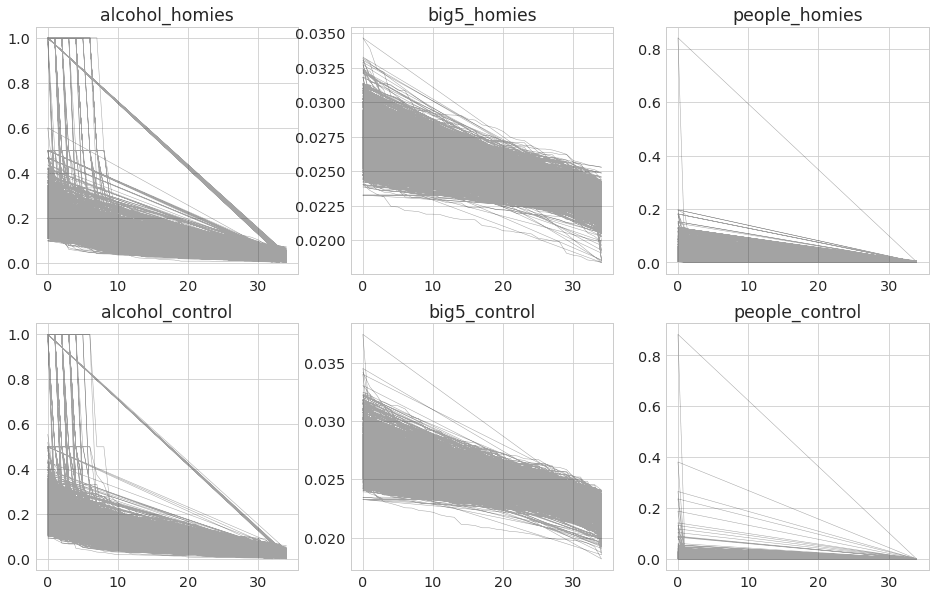

In [4]:
fig, ((ax11, ax12, ax13), (ax21, ax22, ax23)) = plt.subplots(2, 3, figsize=(16, 10))
df_alcohol.alcohol_homies.plot(ax=ax11, alpha=0.4, lw=0.5, color='k')
ax11.set_title('alcohol_homies')
df_big5.big5_homies.plot(ax=ax12, alpha=0.4, lw=0.5, color='k')
ax12.set_title('big5_homies')
df_people.people_homies.plot(ax=ax13, alpha=0.4, lw=0.5, color='k')
ax13.set_title('people_homies')

df_alcohol.alcohol_control.plot(ax=ax21, alpha=0.4, lw=0.5, color='k')
ax21.set_title('alcohol_control')
df_big5.big5_control.plot(ax=ax22, alpha=0.4, lw=0.5, color='k')
ax22.set_title('big5_control')
df_people.people_control.plot(ax=ax23, alpha=0.4, lw=0.5, color='k')
ax23.set_title('people_control')
